# Example Markowitz

## Empirical Forecast
### Example of backtest with Mean-Variance strategy with a simple empirical forecaster

In [1]:
using Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/otherpackages/PortfolioOpt.jl/examples/Project.toml`


In [2]:
using COSMO
using Distributions
using Plots
using Plots.PlotMeasures
using PortfolioOpt
using PortfolioOpt.TestUtils

In [3]:
# Read Prices
prices = get_test_data();
numD, numA = size(prices) # A: Assets    D: Days

# Calculating returns
returns_series = percentchange(prices);

day2float(day) = float(parse(Int, (replace(replace(string(day), " day" => ""), "s" => ""))))

plot_dates = timestamp(returns_series)[1:120];
train_dates = plot_dates[1:99];
test_dates = plot_dates[100:end];
all_days = plot_dates - minimum(plot_dates);
x_plot = day2float.(all_days);
x_train = x_plot[1:99];
x_test = x_plot[100:end];
y_train = values(returns_series[plot_dates[1:99]]);
y_test = values(returns_series[plot_dates[100:end]]);

# normalise the observations
ymean = mean(y_train);
ystd = std(y_train);
y_train_norm = (y_train .- ymean) ./ ystd;

# Backtest Parameters
DEFAULT_SOLVER = optimizer_with_attributes(
    COSMO.Optimizer, "verbose" => false, "max_iter" => 900000
)

date_range = timestamp(returns_series)[100:end];

# Backtest
backtest_results = Dict()
backtest_results["EP_markowitz_limit_var"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60

    # Prep
    numD, numA = size(past_returns)
    returns = values(past_returns)

    # Forecast
    Σ, r̄ = mean_variance(returns[(end - k_back):end, :])
    d = MvNormal(r̄, Σ)

    # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedReturn(d)),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

backtest day 2010-01-26
backtest day 2010-01-27
backtest day 2010-01-28
backtest day 2010-01-29
backtest day 2010-02-01
backtest day 2010-02-02
backtest day 2010-02-03
backtest day 2010-02-04
backtest day 2010-02-05
backtest day 2010-02-08
backtest day 2010-02-09
backtest day 2010-02-10
backtest day 2010-02-11
backtest day 2010-02-12
backtest day 2010-02-16
backtest day 2010-02-17
backtest day 2010-02-18
backtest day 2010-02-19
backtest day 2010-02-22
backtest day 2010-02-23
backtest day 2010-02-24
backtest day 2010-02-25
backtest day 2010-02-26
backtest day 2010-03-01
backtest day 2010-03-02
backtest day 2010-03-03
backtest day 2010-03-04
backtest day 2010-03-05
backtest day 2010-03-08
backtest day 2010-03-09
backtest day 2010-03-10
backtest day 2010-03-11
backtest day 2010-03-12
backtest day 2010-03-15
backtest day 2010-03-16
backtest day 2010-03-17
backtest day 2010-03-18
backtest day 2010-03-19
backtest day 2010-03-22
backtest day 2010-03-23
backtest day 2010-03-24
backtest day 201

## GP Forecast
### First we train the forecaster offline
Note that the chosen kernel is not well suited to this task, so this is not really a fair comparison

In [4]:
# Load our GP-related packages.
using AbstractGPs
using KernelFunctions
using LinearMixingModels
using LinearAlgebra
using KernelFunctions: MOInputIsotopicByOutputs
using Optim # Standard optimisation algorithms.
using ParameterHandling # Helper functionality for dealing with model parameters.
# using Zygote # Algorithmic Differentiation
using ForwardDiff
using ParameterHandling: flatten
using PrincipledRisk
using FactorisedDistributions
using Flux


# Prep forecaster
num_latent_variables = 3
U, S, _ = svd(rand(numA, num_latent_variables));

period = 7.0  # assume weekly periodicity
len_init = period * 5.0
period_len_init = 0.5

flat_initial_params, unflatten = flatten((
    len = positive(len_init),
    period_len = positive(period_len_init),  # bound this param to prevent numerical errors
    var_noise = positive(0.1),
    H = Matrix(Orthogonal(U, Diagonal(S)))
))

# Construct a function to unpack flattened parameters and pull out the raw values.
unpack = ParameterHandling.value ∘ unflatten
params = unpack(flat_initial_params)

# TODO: our desired kernel doesn't work with LinearMixingModels, raise an issue
function build_gp(θ)
    k_maper = compose(MAPeriodicKernel(; r=[θ.period_len]), ScaleTransform(1 / period))
    k_rq = with_lengthscale(RationalQuadraticKernel(), θ.len)
    sogp = GP(k_rq * k_maper)
    latent_gp = independent_mogp([sogp for _ in 1:num_latent_variables]);
    return ILMM(latent_gp, θ.H);
end

x_train_gp = MOInputIsotopicByOutputs(x_train, numA);
y_train_gp = vec(y_train_norm);

function objective(θ)
    ilmm = build_gp(θ)
    return -logpdf(ilmm(x_train_gp, θ.var_noise), y_train_gp)
end

objective(params)

# Optimise using Optim.
training_results = Optim.optimize(
    objective ∘ unpack,
    # θ -> only(Zygote.gradient(objective ∘ unpack, θ)),
    θ -> ForwardDiff.gradient(objective ∘ unpack, θ),
    flat_initial_params,
    BFGS(
        alphaguess = Optim.LineSearches.InitialStatic(scaled=true),
        linesearch = Optim.LineSearches.BackTracking(),
    ),
    Optim.Options(show_trace = true, iterations=50);
    inplace=false,
)

# Extracting the final values of the parameters.
# Should be close to truth.
final_params = unpack(training_results.minimizer);

# Test Predict
x_plot_gp = MOInputIsotopicByOutputs(x_plot, numA);
# x_test_gp = MOInputIsotopicByOutputs(x_test, numA);

ilmm = build_gp(final_params);
# TODO: it is unclear whether var_noise should be included at both steps here
ilmmx = ilmm(x_train_gp, final_params.var_noise);
p_ilmmx = posterior(ilmmx, y_train_gp);
p_i = p_ilmmx(x_plot_gp, final_params.var_noise);  # TODO: check whether obs noise needs to be injected here
marg_pi = marginals(p_i);

# un-normalise the predictions
marg_pi_unnorm = marg_pi .* ystd .+ ymean;

Iter     Function value   Gradient norm 
     0     2.189306e+03     1.838740e+03
 * time: 0.016782045364379883
     1     1.086197e+03     5.281358e+02
 * time: 0.45372486114501953
     2     1.056814e+03     5.168727e+02
 * time: 0.5767509937286377
     3     1.050223e+03     5.017388e+02
 * time: 0.6640958786010742
     4     1.017607e+03     4.204101e+02
 * time: 0.7242019176483154
     5     9.948857e+02     3.476736e+02
 * time: 0.7890949249267578
     6     9.764905e+02     2.889766e+02
 * time: 0.8507750034332275
     7     9.570526e+02     2.094196e+02
 * time: 0.9189639091491699
     8     9.409593e+02     1.833398e+02
 * time: 0.9723999500274658
     9     9.277828e+02     1.611702e+02
 * time: 1.0344569683074951
    10     9.253406e+02     1.608170e+02
 * time: 1.0936369895935059
    11     9.142158e+02     1.652262e+02
 * time: 1.1442070007324219
    12     8.984987e+02     1.536476e+02
 * time: 1.2082829475402832
    13     8.828972e+02     1.388315e+02
 * time: 1.2628879

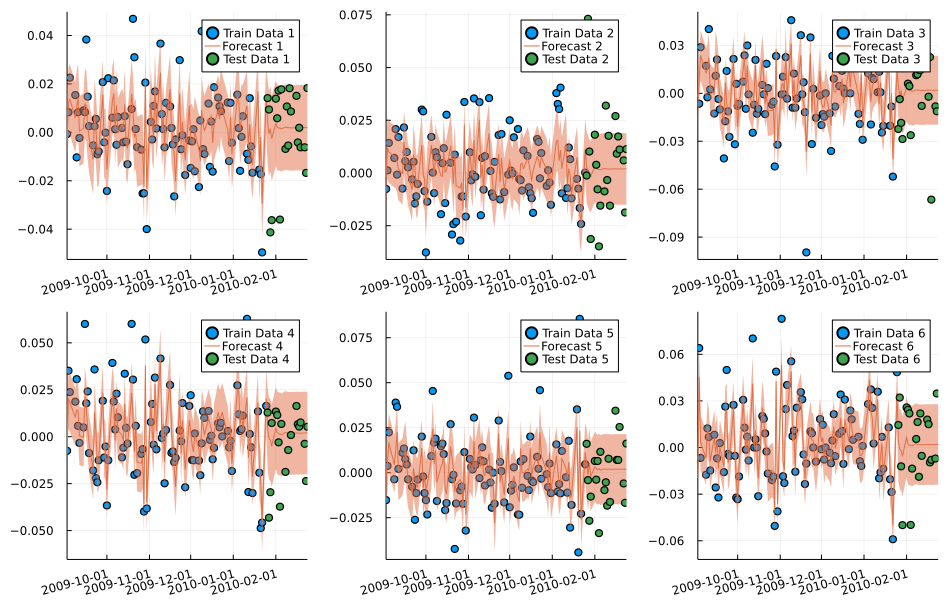

In [5]:
xmin = minimum(plot_dates);
xmax = maximum(plot_dates);
num_plot = length(plot_dates);
plt = Array{Any}(undef, numA);
for i=1:numA
    plt[i] = scatter(train_dates, y_train[:, i]; label = "Train Data $i", size=(900, 700), Title="Asset $i");
    plot!(plt[i], plot_dates, mean.(marg_pi_unnorm[num_plot*(i-1)+1:num_plot*(i)]); ribbon=std.(marg_pi_unnorm[num_plot*(i-1)+1:num_plot*(i)]), label = "Forecast $i", xlims=(xmin, xmax));
    scatter!(plt[i], test_dates, y_test[:, i]; label = "Test Data $i")
end
plot(plt..., size=(950, 600), xrotation = 15)

### Now we run a backtest

In [6]:
backtest_results["GP_markowitz_limit_var"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60

    # Prep
    numD, numA = size(past_returns)

    # Forecast
    dates_for_training = timestamp(past_returns)[end-k_back:end]
    days_for_training = dates_for_training - minimum(dates_for_training)
    day_for_test = ext[:date] - minimum(dates_for_training)
    x_train_gp = MOInputIsotopicByOutputs(day2float.(days_for_training), numA)
    x_test_gp = MOInputIsotopicByOutputs([day2float(day_for_test)], numA)
    y_train = values(past_returns[dates_for_training])
    y_train_gp = vec((y_train .- ymean) ./ ystd)  # normalise the observations

    ilmm = build_gp(final_params)
    # TODO: it is unclear whether var_noise should be included at both steps here
    ilmmx = ilmm(x_train_gp, final_params.var_noise)
    p_ilmmx = posterior(ilmmx, y_train_gp)
    d = p_ilmmx(x_test_gp, final_params.var_noise)
    # un-normalise the predictions
    r̄ = mean(d) .* ystd .+ ymean
    Σ = cov(d) .* ystd^2
    d = MvNormal(r̄, Σ)

    # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedReturn(d)),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

backtest day 2010-01-26
backtest day 2010-01-27
backtest day 2010-01-28
backtest day 2010-01-29
backtest day 2010-02-01
backtest day 2010-02-02
backtest day 2010-02-03
backtest day 2010-02-04
backtest day 2010-02-05
backtest day 2010-02-08
backtest day 2010-02-09
backtest day 2010-02-10
backtest day 2010-02-11
backtest day 2010-02-12
backtest day 2010-02-16
backtest day 2010-02-17
backtest day 2010-02-18
backtest day 2010-02-19
backtest day 2010-02-22
backtest day 2010-02-23
backtest day 2010-02-24
backtest day 2010-02-25
backtest day 2010-02-26
backtest day 2010-03-01
backtest day 2010-03-02
backtest day 2010-03-03
backtest day 2010-03-04
backtest day 2010-03-05
backtest day 2010-03-08
backtest day 2010-03-09
backtest day 2010-03-10
backtest day 2010-03-11
backtest day 2010-03-12
backtest day 2010-03-15
backtest day 2010-03-16
backtest day 2010-03-17
backtest day 2010-03-18
backtest day 2010-03-19
backtest day 2010-03-22
backtest day 2010-03-23
backtest day 2010-03-24
backtest day 201

## GPRN Forecast
### First we train the forecaster offline

In [7]:
num_latents = num_latent_variables + numA * num_latent_variables;
num_weights = num_latents-num_latent_variables;

# define the likelihood model:
likelihood(θ) = GPRNLikelihood(numA, num_latent_variables, θ.output_noise_scale, θ.latent_noise_scale)

# TODO: how should we initialise?
len_latent_init = period * 5.0
len_weight_init = period * 10.0  # the mixing weights should vary more slowly
period_len_latent_init = 0.5
period_len_weight_init = 2.0

θ_latents = (;  # hyperparameters for the GP prior latent factors
    len=positive(len_latent_init),
    period_len=positive(period_len_latent_init),
);

θ_weights = (;  # hyperparameters for the GP prior weight factors
    len=positive(len_weight_init),
    period_len=positive(period_len_weight_init),
);

θ_lik = (;  # hyperparameters for the likelihood model
    output_noise_scale=positive.(0.1ones(numA)),
    latent_noise_scale=positive.(0.25ones(num_latent_variables)),
);

θ_init = (;  # all hyperparameters
    factors = vcat(
        repeat([θ_latents], num_latent_variables),
        repeat([θ_weights], num_weights),
    ),
    lik = θ_lik
);


function kernel(θ)
    k_maper = compose(MAPeriodicKernel(; r=[θ.period_len]), ScaleTransform(1 / period))
    k_rq = with_lengthscale(RationalQuadraticKernel(), θ.len)
    return k_rq * k_maper
end

gp_model = UnevaluatedLatentFactorisedGP(
    repeat([UnevaluatedGP(kernel)], num_latents),
    likelihood
)


function hyperprior(θ)
    """ a Gaussian prior over the kernel lengthscales """
    lens = map(f -> f.len, θ.factors)
    period_lens = map(f -> f.period_len, θ.factors)
    lprior = MvNormal(
        vcat(len_latent_init*ones(num_latent_variables), len_weight_init*ones(num_weights)),
        Diagonal(vcat(20.0ones(num_latent_variables), 40.0ones(num_weights)))
        )
    plprior = MvNormal(
        vcat(period_len_latent_init*ones(num_latent_variables), period_len_weight_init*ones(num_weights)),
        Diagonal(vcat(1.0ones(num_latent_variables), 1.0ones(num_weights)))
        )
    return logpdf(lprior, lens) + logpdf(plprior, period_lens)
end

y_train_gprn = RowVecs(y_train_norm);

println("training model...")
lr_newton = 0.3;
lr_adam = 0.05;
num_iters = 50;
opt = ADAM(lr_adam);
cubature = Unscented3rdOrder(num_latents);
post, θ_opt = train(
    x_train,
    y_train_gprn,
    gp_model,
    θ_init,
    num_iters,
    lr_newton,
    opt,
    cubature,
    hyperprior
);
# println(ParameterHandling.value(θ))

marginal_posterior_predictive = predict_in_data_space(post, x_plot, cubature);
marg_mean = vecvec_to_matrix(mean.(marginal_posterior_predictive));
marg_std = vecvec_to_matrix((diag.(cov.(marginal_posterior_predictive)))) .^ 0.5;

# un-normalise the predictions
marg_mean_unnorm = marg_mean .* ystd .+ ymean;
marg_std_unnorm = marg_std .* ystd;

training model...
iter  1, NLML: 1641.4744 
iter  2, NLML: 1435.2071 
iter  3, NLML: 1355.7918 
iter  4, NLML: 1301.0889 
iter  5, NLML: 1257.3313 
iter  6, NLML: 1220.1699 
iter  7, NLML: 1187.6239 
iter  8, NLML: 1158.5178 
iter  9, NLML: 1132.1364 
iter 10, NLML: 1108.0775 
iter 11, NLML: 1086.0715 
iter 12, NLML: 1065.9297 
iter 13, NLML: 1047.5094 
iter 14, NLML: 1030.6832 
iter 15, NLML: 1015.2771 
iter 16, NLML: 1000.8683 
iter 17, NLML: 985.3141 
iter 18, NLML: 961.4827 
iter 19, NLML: 934.8202 
iter 20, NLML: 915.6326 
iter 21, NLML: 900.9673 
iter 22, NLML: 889.6519 
iter 23, NLML: 880.5798 
iter 24, NLML: 873.3005 
iter 25, NLML: 867.7691 
iter 26, NLML: 863.5696 
iter 27, NLML: 860.2775 
iter 28, NLML: 857.6386 
iter 29, NLML: 855.4901 
iter 30, NLML: 853.7416 
iter 31, NLML: 852.3391 
iter 32, NLML: 851.2389 
iter 33, NLML: 850.3905 
iter 34, NLML: 849.7396 
iter 35, NLML: 849.2360 
iter 36, NLML: 848.8380 
iter 37, NLML: 848.5185 
iter 38, NLML: 848.2643 
iter 39, NLML: 8

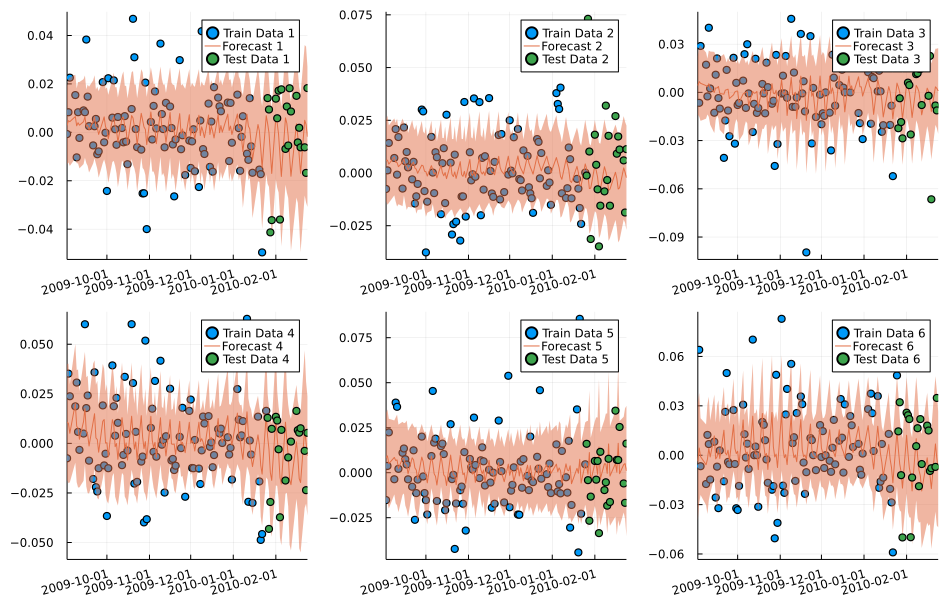

In [8]:
plt = Array{Any}(undef, numA);
for i=1:numA
    plt[i] = scatter(train_dates, y_train[:, i]; label = "Train Data $i", size=(900, 700), Title="Asset $i");
    plot!(plt[i], plot_dates, marg_mean_unnorm[:, i]; ribbon=marg_std_unnorm[:, i], label = "Forecast $i", xlims=(xmin, xmax));
    scatter!(plt[i], test_dates, y_test[:, i]; label = "Test Data $i")
end
plot(plt..., size=(950, 600), xrotation = 15)

### We can also measure the uncertainty in the noise covariance

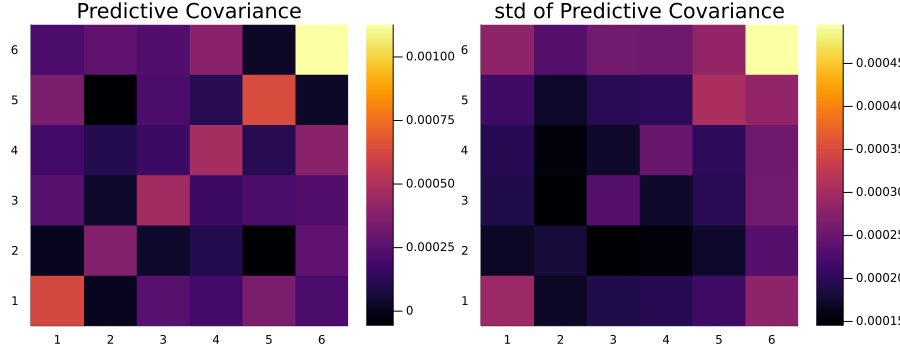

In [9]:
# function sample_noise_cov(p, latent_prediction::AbstractMvNormal, num_samps)
#     predsamp = rand.(repeat([latent_prediction], num_samps))
#     moments = conditional_moments.((p.prior.lik, ), predsamp)
#     secondmoment = map(m -> m[3], moments)
#     return secondmoment
# end

# sample_noise_cov(p, latent_prediction::AbstractVector{<:AbstractMvNormal}, num_samps) = sample_noise_cov.((p, ), latent_prediction, (num_samps, ))

function sample_cov(p, latent_prediction::AbstractMvNormal, num_samps)
    l = p.prior.lik
    predsamp = rand.(repeat([latent_prediction], num_samps))
    # the following is based on the specific form of the GPRNLikelihood from PrincipledRisk.jl
    F_cov = cov(latent_prediction)[1:l.latent_dim, 1:l.latent_dim] + Diagonal(l.latent_noise_scale)
    W_samp = map(p -> p[l.latent_dim+1:end] .+ l.additive_const, predsamp)  # sample the weights
    W_samp = reshape.(W_samp, l.output_dim, l.latent_dim)
    sample_cov = W_samp .* (F_cov, ) .* transpose.(W_samp) .+ (Diagonal(l.output_noise_scale), )
    return sample_cov
end

sample_cov(p, latent_prediction::AbstractVector{<:AbstractMvNormal}, num_samps) = sample_cov.((p, ), latent_prediction, (num_samps, ))


# measure the uncertainty in the noise covariance at a single test point
test_pred = predict_in_data_space(post, x_test[1:1], cubature);
testcov_unnorm = cov(only(test_pred)) .* ystd^2;
latent_predict = predict(post, x_test[1:1]);
s_cov = sample_cov(post, latent_predict, 5000);
s_cov_unnorm = s_cov .* ystd^2;
# cov_mean = mean.(s_cov_unnorm);
cov_std = std.(s_cov_unnorm);

p1 = heatmap(testcov_unnorm, title="Predictive Covariance");
p2 = heatmap(only(cov_std), title="std of Predictive Covariance");
plot(p1, p2, size=(900, 350))

### Now run a backtest with the GPRN forecaster
This involves re-fitting the variational parameters every time, so takes longer than the previous backtests

In [10]:
backtest_results["GPRN_markowitz_limit_var"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60

    # Prep
    numD, numA = size(past_returns)

    # Forecast
    dates_for_training = timestamp(past_returns)[end-k_back:end]
    days_for_training = dates_for_training - minimum(dates_for_training)
    day_for_test = ext[:date] - minimum(dates_for_training)
    x_train_gprn = day2float.(days_for_training)
    x_test_gprn = [day2float(day_for_test)]
    y_train = values(past_returns[dates_for_training])
    y_train_gprn = RowVecs((y_train .- ymean) ./ ystd)  # normalise the observations

    # need to re-fit the variational parameters
    num_iters_backtest = 7
    opt_backtest = ADAM(0.0)  # don't change the hyperparameters
    post, θ_opt = train(
        x_train_gprn,
        y_train_gprn,
        gp_model,
        θ_init,
        num_iters_backtest,
        lr_newton,
        opt_backtest,
        cubature,
        hyperprior
    )

    pred = only(predict_in_data_space(post, x_test_gprn, cubature))
    # un-normalise the predictions
    r̄ = mean(pred) .* ystd .+ ymean
    Σ = cov(pred) .* ystd^2
    d = MvNormal(r̄, Σ)

    # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedReturn(d)),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

backtest day 2010-01-26
iter  1, NLML: 1117.2868 
iter  2, NLML: 900.0973 
iter  3, NLML: 842.1541 
iter  4, NLML: 822.5863 
iter  5, NLML: 813.7325 
iter  6, NLML: 808.9230 
iter  7, NLML: 806.2133 
backtest day 2010-01-27
iter  1, NLML: 1123.6149 
iter  2, NLML: 904.9475 
iter  3, NLML: 845.5904 
iter  4, NLML: 825.9491 
iter  5, NLML: 817.0696 
iter  6, NLML: 812.2320 
iter  7, NLML: 809.5217 
backtest day 2010-01-28
iter  1, NLML: 1147.9439 
iter  2, NLML: 950.5387 
iter  3, NLML: 901.1320 
iter  4, NLML: 879.1130 
iter  5, NLML: 865.9601 
iter  6, NLML: 859.4632 
iter  7, NLML: 856.7268 
backtest day 2010-01-29
iter  1, NLML: 1139.5234 
iter  2, NLML: 985.6672 
iter  3, NLML: 955.3409 
iter  4, NLML: 936.6770 
iter  5, NLML: 922.7813 
iter  6, NLML: 910.9671 
iter  7, NLML: 900.9914 
backtest day 2010-02-01
iter  1, NLML: 1140.4111 
iter  2, NLML: 989.6850 
iter  3, NLML: 957.5314 
iter  4, NLML: 936.0481 
iter  5, NLML: 918.3079 
iter  6, NLML: 904.1810 
iter  7, NLML: 895.0298 


iter  2, NLML: 921.5660 
iter  3, NLML: 903.8202 
iter  4, NLML: 892.0110 
iter  5, NLML: 884.3155 
iter  6, NLML: 879.4778 
iter  7, NLML: 876.4792 
backtest day 2010-03-26
iter  1, NLML: 1002.7963 
iter  2, NLML: 915.9442 
iter  3, NLML: 896.7168 
iter  4, NLML: 883.3551 
iter  5, NLML: 874.7921 
iter  6, NLML: 869.8791 
iter  7, NLML: 866.9756 
backtest day 2010-03-29
iter  1, NLML: 1009.1943 
iter  2, NLML: 916.0297 
iter  3, NLML: 895.5230 
iter  4, NLML: 881.6444 
iter  5, NLML: 872.8903 
iter  6, NLML: 867.8812 
iter  7, NLML: 864.9215 
backtest day 2010-03-30
iter  1, NLML: 1017.5166 
iter  2, NLML: 918.0516 
iter  3, NLML: 897.0631 
iter  4, NLML: 883.1709 
iter  5, NLML: 874.5493 
iter  6, NLML: 869.7604 
iter  7, NLML: 866.9576 
backtest day 2010-03-31
iter  1, NLML: 1014.6477 
iter  2, NLML: 912.2079 
iter  3, NLML: 891.9952 
iter  4, NLML: 879.1174 
iter  5, NLML: 871.4444 
iter  6, NLML: 867.3189 
iter  7, NLML: 864.9019 
backtest day 2010-04-01
iter  1, NLML: 1013.7459 


iter  4, NLML: 703.3448 
iter  5, NLML: 689.2922 
iter  6, NLML: 681.8283 
iter  7, NLML: 677.3835 
backtest day 2010-05-25
iter  1, NLML: 1028.4957 
iter  2, NLML: 801.3869 
iter  3, NLML: 741.3478 
iter  4, NLML: 714.1289 
iter  5, NLML: 700.3226 
iter  6, NLML: 692.5442 
iter  7, NLML: 687.7426 
backtest day 2010-05-26
iter  1, NLML: 999.9650 
iter  2, NLML: 785.8635 
iter  3, NLML: 733.4128 
iter  4, NLML: 710.3280 
iter  5, NLML: 698.4141 
iter  6, NLML: 691.6363 
iter  7, NLML: 687.4214 
backtest day 2010-05-27
iter  1, NLML: 1003.2558 
iter  2, NLML: 781.3627 
iter  3, NLML: 727.6018 
iter  4, NLML: 706.7176 
iter  5, NLML: 695.9475 
iter  6, NLML: 689.5092 
iter  7, NLML: 685.3446 
backtest day 2010-05-28
iter  1, NLML: 1060.4645 
iter  2, NLML: 824.1482 
iter  3, NLML: 751.0790 
iter  4, NLML: 720.9584 
iter  5, NLML: 706.7144 
iter  6, NLML: 698.5509 
iter  7, NLML: 693.3248 
backtest day 2010-06-01
iter  1, NLML: 1075.6756 
iter  2, NLML: 834.2772 
iter  3, NLML: 759.0668 
i

iter  4, NLML: 793.8021 
iter  5, NLML: 772.4353 
iter  6, NLML: 761.9411 
iter  7, NLML: 756.2583 
backtest day 2010-07-23
iter  1, NLML: 1240.8502 
iter  2, NLML: 944.9026 
iter  3, NLML: 836.2429 
iter  4, NLML: 785.9469 
iter  5, NLML: 763.2361 
iter  6, NLML: 752.1625 
iter  7, NLML: 746.2467 
backtest day 2010-07-26
iter  1, NLML: 1168.5471 
iter  2, NLML: 907.8896 
iter  3, NLML: 818.3778 
iter  4, NLML: 780.4706 
iter  5, NLML: 763.0046 
iter  6, NLML: 754.0928 
iter  7, NLML: 749.0837 
backtest day 2010-07-27
iter  1, NLML: 1161.6714 
iter  2, NLML: 905.3958 
iter  3, NLML: 816.9999 
iter  4, NLML: 778.5434 
iter  5, NLML: 760.5834 
iter  6, NLML: 751.4266 
iter  7, NLML: 746.3254 
backtest day 2010-07-28
iter  1, NLML: 1176.3645 
iter  2, NLML: 905.7076 
iter  3, NLML: 817.7353 
iter  4, NLML: 780.3517 
iter  5, NLML: 763.1404 
iter  6, NLML: 754.3035 
iter  7, NLML: 749.2953 
backtest day 2010-07-29
iter  1, NLML: 1110.5896 
iter  2, NLML: 879.9491 
iter  3, NLML: 805.2790 


iter  6, NLML: 579.8672 
iter  7, NLML: 578.0812 
backtest day 2010-09-21
iter  1, NLML: 712.6701 
iter  2, NLML: 620.2622 
iter  3, NLML: 594.1231 
iter  4, NLML: 584.8972 
iter  5, NLML: 580.3171 
iter  6, NLML: 577.4916 
iter  7, NLML: 575.5134 
backtest day 2010-09-22
iter  1, NLML: 692.1386 
iter  2, NLML: 605.5555 
iter  3, NLML: 580.8523 
iter  4, NLML: 572.1082 
iter  5, NLML: 567.7248 
iter  6, NLML: 564.9692 
iter  7, NLML: 563.0056 
backtest day 2010-09-23
iter  1, NLML: 723.4689 
iter  2, NLML: 619.0330 
iter  3, NLML: 584.1172 
iter  4, NLML: 573.0820 
iter  5, NLML: 568.1693 
iter  6, NLML: 565.1971 
iter  7, NLML: 563.1292 
backtest day 2010-09-24
iter  1, NLML: 718.4758 
iter  2, NLML: 619.3124 
iter  3, NLML: 588.7441 
iter  4, NLML: 576.9681 
iter  5, NLML: 570.8687 
iter  6, NLML: 567.0188 
iter  7, NLML: 564.3125 
backtest day 2010-09-27
iter  1, NLML: 630.0927 
iter  2, NLML: 568.6645 
iter  3, NLML: 553.4532 
iter  4, NLML: 549.3633 
iter  5, NLML: 547.4422 
iter 

backtest day 2010-11-17
iter  1, NLML: 655.2888 
iter  2, NLML: 620.0907 
iter  3, NLML: 615.7615 
iter  4, NLML: 614.2271 
iter  5, NLML: 613.2028 
iter  6, NLML: 612.2901 
iter  7, NLML: 611.4263 
backtest day 2010-11-18
iter  1, NLML: 654.3590 
iter  2, NLML: 620.0004 
iter  3, NLML: 615.6313 
iter  4, NLML: 614.0024 
iter  5, NLML: 612.8229 
iter  6, NLML: 611.7216 
iter  7, NLML: 610.6560 
backtest day 2010-11-19
iter  1, NLML: 683.8798 
iter  2, NLML: 652.8932 
iter  3, NLML: 647.0172 
iter  4, NLML: 643.9255 
iter  5, NLML: 641.5456 
iter  6, NLML: 639.4752 
iter  7, NLML: 637.6401 
backtest day 2010-11-22
iter  1, NLML: 689.7032 
iter  2, NLML: 656.3948 
iter  3, NLML: 650.5031 
iter  4, NLML: 647.4488 
iter  5, NLML: 645.0925 
iter  6, NLML: 643.0492 
iter  7, NLML: 641.2422 
backtest day 2010-11-23
iter  1, NLML: 690.4677 
iter  2, NLML: 656.3059 
iter  3, NLML: 650.2115 
iter  4, NLML: 647.2498 
iter  5, NLML: 644.9568 
iter  6, NLML: 642.9468 
iter  7, NLML: 641.1418 
backt

## Plot Backtest Results

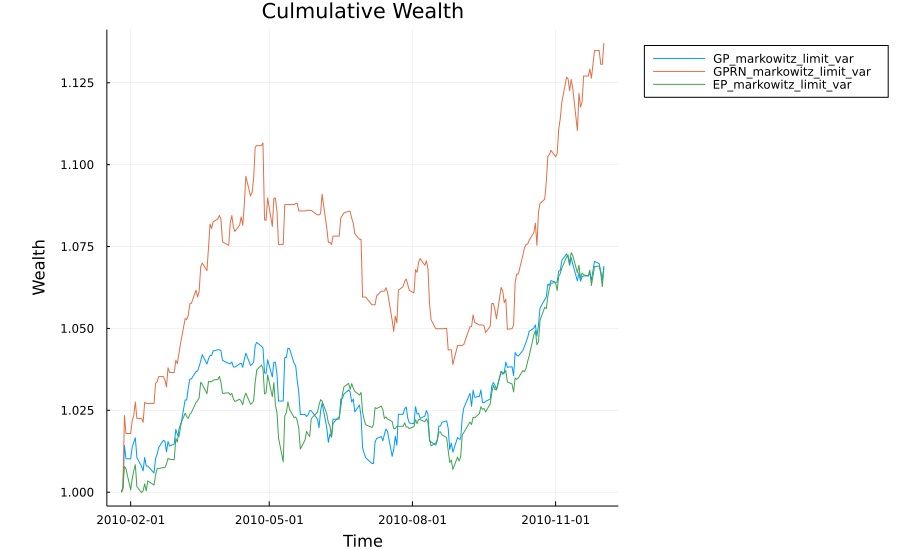

In [11]:
plt = plot(;title="Culmulative Wealth",
    xlabel="Time",
    ylabel="Wealth",
    legend=:outertopright,
    left_margin=10mm,
    size=(900, 550)
);
for (strategy_name, recorders) in backtest_results
    plot!(plt,
        axes(get_records(recorders[:wealth]), 1), get_records(recorders[:wealth]).data;
        label=strategy_name,
    )
end
plt